Force Sensor

In [1]:
import nidaqmx 
import atiiaftt as ati
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
CALFILEPATH = "FT44764\FT44764.cal"
INDEX = 1

with nidaqmx.Task() as task:
    task.ai_channels.add_ai_voltage_chan("Dev1/ai0")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai1")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai2")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai3")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai4")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai5")
    
    bias = task.read()
    reading = task.read()

transform = [0,0,0,0,0,0]

#Bias
sensor = ati.FTSensor()
cal = sensor.createCalibration(CALFILEPATH, INDEX)
sensor.setForceUnits("N".encode("utf-8"))
sensor.setTorqueUnits("N-m".encode("utf-8"))
sensor.setToolTransform(transform, "mm".encode("utf-8"), "deg".encode("utf-8"))

sensor.bias(bias)
output = sensor.convertToFt(reading)
output

[0.013714807108044624,
 0.0026834295131266117,
 0.011954753659665585,
 0.0002611366508062929,
 -0.0001542144746053964,
 -6.84399128658697e-05]

Test Sensor

In [3]:
current_time = time.time()
duration = 5
readings = []
while time.time() < current_time+duration:
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan("Dev1/ai0")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai1")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai2")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai3")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai4")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai5")

        reading = sensor.convertToFt(task.read())
        print(reading)
        readings.append(reading)

print("Number of Data", len(readings))

[0.013960414566099644, 0.0025002090260386467, -0.01663883402943611, -8.63184395711869e-05, 0.00032043253304436803, 0.0005705783260054886]
[0.023186001926660538, 0.01063842698931694, -0.03326546773314476, 0.00024877130636014044, -0.0003234237665310502, 0.0005736781749874353]
[0.0068879202008247375, 0.004049606621265411, -0.020744331181049347, 0.00041178290848620236, -0.00014118457329459488, 0.0004361537576187402]
[0.002211976796388626, 0.014670788310468197, 0.004256067331880331, 5.669162783306092e-05, -9.630560816731304e-05, -6.624124216614291e-05]
[0.013846253976225853, 0.005240755621343851, -0.008519475348293781, 0.00018057506531476974, 0.00018642844224814326, 0.0002878447703551501]
[0.011540469713509083, 0.0039440421387553215, -0.008376316167414188, 4.869544500252232e-05, 6.221649528015405e-06, 0.00043166993418708444]
[0.016091154888272285, 0.009243160486221313, -0.00013581058010458946, -8.654278644826263e-06, 1.9672661437653005e-05, 0.0005055677611380816]
[0.009146621450781822, 0.00

Initiallize Motor

In [5]:
import numpy as np
import datetime as dt
import csv
import matplotlib.pyplot as plt
import serial
from time import sleep


ENTER = bytes([0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFC])
EXIT = bytes([0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFD])
ZERO = bytes([0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFF, 0xFE])


# AK70-10 24V Motor Limit
P_MIN = -12.5
P_MAX = 12.5
V_MIN = -50  
V_MAX = 50
T_MIN = -25 
T_MAX = 25
KP_MIN = 0
KP_MAX = 500
KD_MIN = 0
KD_MAX = 5

Function

In [6]:
def unpack(data):
    id = data[0]
    pos = ((data[1]*(P_MAX-P_MIN))/(pow(2,16)-1)) + P_MIN
    vel = ((data[2]*(V_MAX-V_MIN))/(pow(2,12)-1)) + V_MIN
    tor = ((data[3]*(T_MAX-T_MIN))/(pow(2,12)-1)) + T_MIN
    return id, pos, vel, tor

def receive():
    global dT, q1_old, q2_old
    # Read the response from the serial port
    received = ser.readline().decode().split()      

    # Print the received bytes
    # print("Received:", received)

    try:
        test = int(received[0])
        response = [int(x) for x in received]
        [id, p, v, t] = unpack(response)

        if id == 1:
            p = -round(p,3)
            t = -t
            if dT == 0:
                v = 0
            else:
                v = round((p - q1_old)/dT,2)
        
        else:
            p = round(p,3)
            t = t
            if dT == 0:
                v = 0
            else:
                v = round((p-q2_old)/dT,2)

        # print the response from the Arduino
        # print([id, p, v, t])

    except (IndexError, ValueError):
        id = None
        p = 0
        v = 0
        t = 0
    return id, p, v, t

def pack_cmd(p_des, v_des, t_ff, kp, kd):
    bufs = []
    def float_to_uint(val, val_min, val_max, bits):
        val_norm = (val - val_min) / (val_max - val_min)
        val_int = int(round(val_norm * ((1 << bits) - 1)))
        return val_int
    
    p_int = float_to_uint(p_des, P_MIN, P_MAX, 16)
    v_int = float_to_uint(v_des, V_MIN, V_MAX, 12)
    t_int = float_to_uint(t_ff, T_MIN, T_MAX, 12)
    kp_int = float_to_uint(kp, KP_MIN, KP_MAX, 12)
    kd_int = float_to_uint(kd, KD_MIN, KD_MAX, 12)
    
    bufs.append((p_int >> 8) & 0xFF)
    bufs.append(p_int & 0xFF)
    bufs.append((v_int >> 4) & 0xFF)
    bufs.append(((v_int & 0xF) << 4) | ((kp_int >> 8) & 0xF))
    bufs.append(kp_int & 0xFF)
    bufs.append((kd_int >> 4) & 0xFF)
    bufs.append(((kd_int & 0xF) << 4) | ((t_int >> 8) & 0xF))
    bufs.append(t_int & 0xFF)

    return bufs

Construct Serial Connection

In [7]:
# open the serial port
ser = serial.Serial('COM4', 115200, timeout=1)


Set Zero

In [8]:
print("Begining")


q1_old = 0
pos2_old = 0
dT = 0

#M1
print("Starting Zero Position M1")
ser.write(bytes([0x01])+ZERO)
sleep(3)
[id, p, v, t] = receive()
p = 5
while abs(p) >= 0.001:
    ser.write(bytes([0x01])+ZERO)
    sleep(3)
    [id, p, v, t] = receive()



#M2
print("Starting Zero Position M2")
ser.write(bytes([0x02])+ZERO)
sleep(3)
[id, p, v, t] = receive()
p = 5
while abs(p) >= 0.001:
    ser.write(bytes([0x02])+ZERO)
    sleep(3)
    [id, p, v, t] = receive()

print("Finishing Zero Position")


Begining
Starting Zero Position M1
Starting Zero Position M2
Finishing Zero Position


Enter Motor and Re-bias Force Sensor

In [10]:
##Motor

dT = 0

#M1
print("Starting Enter Motors")
ser.write(bytes([0x01])+ENTER)
[id, p, v, t] = receive()
if id == 1:
    q1 = p
    vel1 = v

elif id == 2:
    q2 = p
    vel2 = v

#M2
ser.write(bytes([0x02])+ENTER)
[id, p, v, t] = receive()

if id == 1:
    q1 = p
    vel1 = v

elif id == 2:
    q2 = p
    vel2 = v

q1_old = q1
q2_old = q2


##Sensor

with nidaqmx.Task() as task:
    task.ai_channels.add_ai_voltage_chan("Dev1/ai0")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai1")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai2")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai3")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai4")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai5")
    
    bias = task.read()

sensor.bias(bias)

Starting Enter Motors


Running

In [11]:
start_time = dt.datetime.today().timestamp()
t = 0
l1 = 0.275
l2 = 0.24
l4 = 0.01
q0 = np.deg2rad(18)
logs = list()
motor_logs = list()
readings = list()

t_mapping = 1/1.35

x = l1*np.sin(q1) + l2*np.cos(q2)
y = l1*np.cos(q1) - l2*np.sin(q2)

time = 0
record_duration = 20

print("Start Controling")
while time < record_duration:
    start_time = dt.datetime.today().timestamp()

    log = list()
    log.append(time)

    q1_old = q1
    q2_old = q2

    x_old = x
    y_old = y


    T1 = 0
    T2 = 0

    
    
    log.append(T1)
    log.append(T2)


    command1 = bytes(pack_cmd(0,0,-T1*t_mapping,0,0)) #(pos,vel,torque,kp,kd)
    command2 = bytes(pack_cmd(0,0,T2*t_mapping,0,0)) #(pos,vel,torque,kp,kd)

    #M1
    ser.write(bytes([0x01])+command1)
    [id, p, v, t] = receive()

    if id == 1:
        q1 = p
        vel1 = v
        t1 = t/t_mapping
    
    elif id == 2:
        q2 = p
        vel2 = v
        t2 = t/t_mapping

    #M2
    ser.write(bytes([0x02])+command2)
    [id, p, v, t] = receive()

    if id == 1:
        q1 = p
        vel1 = v
        t1 = t/t_mapping
    
    elif id == 2:
        q2 = p
        vel2 = v
        t2 = t/t_mapping

    log.append(t1)
    log.append(t2)

    log.append(q1)
    log.append(q2)

    x = l1*np.sin(q1) + l2*np.cos(q2)
    y = l1*np.cos(q1) - l2*np.sin(q2)

    log.append(x)
    log.append(y)

    if time!= 0:
        x_dot = (x-x_old)/dT
        y_dot = (y-y_old)/dT
    
    else:
        x_dot = 0
        y_dot = 0

    log.append(x_dot)
    log.append(y_dot)

    #Estimate CF
    A = q0-q1+2*q2
    B = q0-q1
    C = q0-2*q1+q2
    D = q0+q2
    Fx = -((T1*l2*(np.sin(A)+np.sin(B))+T2*l1*(np.sin(C)-np.sin(D)))/(l1*l2*(np.sin(q0)+np.sin(q0-2*q1+2*q2))))
    Fy = (T1*l2*(np.cos(B)+np.cos(C))+T2*l1*(np.cos(D)-np.cos(A))/(l1*l2*(np.sin(q0)+np.sin(q0-2*q1+2*q2))))    

    log.append(Fx)
    log.append(Fy)

    motor_logs.append(log)


    #Sensor
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan("Dev1/ai0")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai1")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai2")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai3")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai4")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai5")
        reading = sensor.convertToFt(task.read())

  
    #print(reading)
    
    readings.append(reading)

    log.append(-reading[0])
    log.append(-reading[1])

    logs.append(log)
    
    # print("Progress", f'{round(time/record_duration*100,3)}%')
    dT = dt.datetime.today().timestamp()-start_time
    time+= dT

ser.write(bytes([0x01])+EXIT)
receive()

#M2
ser.write(bytes([0x02])+EXIT)
receive()
    

print("finish")
# print(logs)


Start Controling
finish


Emergency Exit

In [ ]:
ser.write(bytes([0x01])+EXIT)
receive()

#M2
ser.write(bytes([0x02])+EXIT)
receive()


In [12]:
##readings

print("Data Sample Size", len(readings))
COLUMNS = ["Force X", "Force Y", "Force Z", "Torque X", "Torque Y", "Torque Z"]
readings
arrays = np.array([np.array(item) for item in readings])

arrays_transpose = arrays.transpose()
df = pd.DataFrame([])
for i in range(len(COLUMNS)):
    df[COLUMNS[i]] = arrays_transpose[i]

print(df)


##logs
print(logs)
logs_COLUMNS = ["Time", "T1", "T2", "t1", "t2", "q1", "q2", "x", "y", "x_dot", "y_dot", "Fx", "Fy", "Fx_Mea", "Fy_Mea"]

logs_arrays = np.array([np.array(item) for item in logs])

logs_arrays_transpose = logs_arrays.transpose()
df_log = pd.DataFrame([])
for i in range(len(logs_COLUMNS)):
    df_log[logs_COLUMNS[i]] = logs_arrays_transpose[i]

print(df_log)

Data Sample Size 553
      Force X   Force Y   Force Z  Torque X  Torque Y  Torque Z
0    0.081506  0.487906 -0.001181 -0.005843 -0.002525 -0.004659
1    0.252570 -0.343148  0.068157 -0.004099  0.001862 -0.001615
2    0.108497  0.063023 -0.016144 -0.004982 -0.013401 -0.007591
3    0.312374 -0.148901 -0.088419 -0.001456  0.013991  0.002385
4   -0.099324 -0.074266  0.017799  0.000072 -0.004862 -0.002150
..        ...       ...       ...       ...       ...       ...
548  0.049552 -0.163427 -0.016081  0.000770 -0.013551 -0.006254
549 -0.076923  0.087731 -0.027223  0.001962  0.009093  0.001425
550 -0.200222  0.303969  0.035626  0.001521  0.014777 -0.000798
551  0.030353 -0.084182  0.030871 -0.000873  0.011566  0.004200
552  0.073648  0.078479 -0.157203  0.002089  0.005646  0.006072

[553 rows x 6 columns]
[[0, 0, 0, -0.008241758241758212, 0.024725274725274637, -0.0, 0.0, 0.24, 0.275, 0, 0, -0.0, 0.0, -0.08150560408830643, -0.48790618777275085], [0.031649112701416016, 0, 0, 0.00824175824175

In [13]:
df_log.to_csv("Joey/Record_Data/Sensor_1.csv")

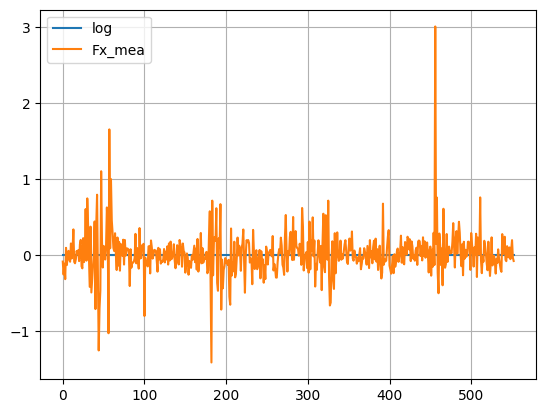

In [14]:
X = df_log.index
Y = df_log["Fx"]
plt.plot(X, Y, label="log")
plt.grid()
plt.plot(X, df_log["Fx_Mea"], label="Fx_mea")
plt.legend()